## Using APIs in Projects


When getting data from APIs, I strongly suggest following a three-step workflow:

1. Write some code that gets data from an API and saves all of the data (if possible) to a file
2. Write a second program (usually a second file) that loads the data from the API, extracts the data that will be useful for analysis, and saves it in a flat file (typically a CSV).
3. Program number 3 loads the CSV file and does the analysis

This approach has a few important benefits.

The first and most important is that often it is difficult to get the same raw data again. If you are using Twitter, then the Search API only lets you get the last week. If you are doing analysis a month down the road and decide that you really wish you had saved metadata about the number of retweets, it is too late. By saving the raw data you can change your measures or analysis strategy and still have access to the data.

The second is that this gives you a nice pipeline, with intermediate files. Instead of including the entire raw data file in the code that does analysis, you only have to load the CSV, which is often much smaller and easier to work with.

This brief lesson will show an example of this workflow, using `tweepy`.

Note that I'm going to put everything in one file for convenience, but my typical workflow is to put these in separate files and then run each file separately.

## Program 1 - Data Retrieval

The goal of our project is to produce a visualization of the histogram of the number of retweets for recent tweets about President Trump. The first program gets tweets about President Trump.

Older versions of tweepy made it easier to get the JSON returned by 

In [111]:
import tweepy
import json
import requests
from twitter_authentication import bearer_token
import pandas as pd
import time

client = tweepy.Client(bearer_token, 
                       return_type=dict, # Without this, tweepy returns an object-based response
                       wait_on_rate_limit=True
                      )

In [113]:
with open('raw_trump_tweets.txt', 'w') as f: # By opening with 'a' (for append) we can write to this file again
                                            # e.g., if we need to restart data collection.
    num_tweets = 4000
    tweet_count = 0
    next_token = None
    
    while tweet_count < num_tweets:
        response = client.search_recent_tweets(
            query='Trump -is:retweet', 
            user_fields = ['username', 'public_metrics', 'description', 'location'],
            tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
            expansions = 'author_id',
            next_token = next_token,
            max_results=100)
        
        next_token = response['meta']['next_token'] # get the "next token", which gives us the next page
        tweets = response['data']
        tweet_count += len(tweets)
        
        f.write(json.dumps(response)+ '\n') # Write each response's JSON as a new line
        time.sleep(.5)

## Program 2 - Data Cleaning

This program loads the saved raw data, grabs what we want, and converts it into a pandas dataframe and a CSV.

I decided to save the timestamp, text, and retweet and favorite counts, together with the public metrics about the author. Tweepy puts author info in an "includes" dictionary, so we have to extract it from there.

This is also where you typically would do more complicated measure creation. Here I show how to create a measure of tweet_length.

In [114]:
with open('raw_trump_tweets.txt', 'r') as f:
    responses = []
    for line in f.readlines():
        responses.append(json.loads(line))

In [115]:
result = []
user_dict = {}
# Loop through each response object
for response in responses:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response['includes']['users']:
        user_dict[user['id']] = {'username': user['username'], 
                              'followers': user['public_metrics']['followers_count'],
                              'tweets': user['public_metrics']['tweet_count']
                             }
    for tweet in response['data']:
        # For each tweet, find the author's information
        author_info = user_dict[tweet['author_id']]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet['author_id'], 
                       'username': author_info['username'],
                       'author_followers': author_info['followers'],
                       'author_tweets': author_info['tweets'],
                       'text': tweet['text'],
                       'created_at': tweet['created_at'],
                       'retweets': tweet['public_metrics']['retweet_count'],
                       'likes': tweet['public_metrics']['like_count'],
                       'tweet_length': len(tweet['text'])
                      })
df = pd.DataFrame(result)
df.to_csv('cleaned_data.csv', index=False)

## Program 3 - Data Analysis

Here we use pandas to load the data and analyze it. This could include statistical tests. Here, I'm just visualizing the distribution of retweets and the relationship between retweets and length.

In [116]:
import pandas as pd
import seaborn as sns

In [117]:
df = pd.read_csv('./cleaned_data.csv')

In [118]:
# Just make sure it looks OK.
df.sort_values('retweets')

,author_id,username,author_followers,author_tweets,text,created_at,retweets,likes,tweet_length
0,1267340330258567168,wavechaser2024,6572,89933,"Just FYI, they would’ve impeached Trump had he...",2022-10-21T02:10:16.000Z,0,0,66
2666,1566874310,PenurieBot,37,1196,Face à la pénurie de viande le gouvernement au...,2022-10-21T01:50:53.000Z,0,0,86
2667,1147245086184550401,TheHomemaking,867,5584,Tell me you've never been on a farm without te...,2022-10-21T01:50:52.000Z,0,4,238
2668,39574889,Twishypoo,127,24742,@mikepompeo Did you ever in your life think va...,2022-10-21T01:50:52.000Z,0,0,135
2669,1560770927218098177,EzekiahMordecai,128,569,Exclusive: Trump adviser Kash Patel has appear...,2022-10-21T01:50:51.000Z,0,0,120
...,...,...,...,...,...,...,...,...,...
3864,2421067430,TeaPainUSA,797970,128201,We need a separation of church and stupid. htt...,2022-10-21T01:42:16.000Z,39,217,66
3725,2640729706,ImSpeaking13,114240,102237,FUCK DONALD TRUMP. GO TO PRISON ALREADY.,2022-10-21T01:43:12.000Z,51,438,40
3102,1298372735383605249,RonFilipkowski,537369,45175,"Fresh out of jail for J6, out on the road with...",2022-10-21T01:47:31.000Z,56,206,100
2112,722528529716383744,ACTBrigitte,579268,27464,President Trump wanted everyone to be as rich ...,2022-10-21T01:54:47.000Z,84,465,121


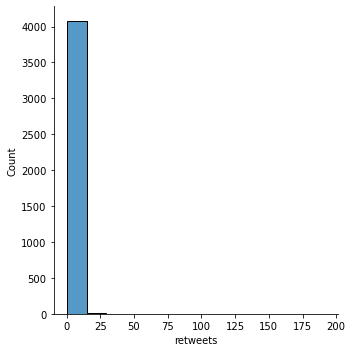

In [119]:
sns.displot(df.retweets)

As expected, it's super skewed, with most tweets never getting retweeted while a few get tons of retweets.

Let's see if it changes if we get rid of the tweets that never got retweeted (like, maybe we have a principled reason to believe they are different than other tweets).

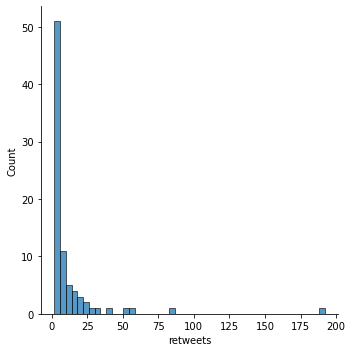

In [120]:
sns.displot(df.loc[df.retweets > 1, 'retweets']);

As I thought, this is a somewhat "scale-free" distribution, meaning wherever you zoom in, you see the same pattern. Try changing the `0` up above to any (small) number.

For fun, let's also look at the relationship between retweets and tweet length.

In [121]:
import numpy as np

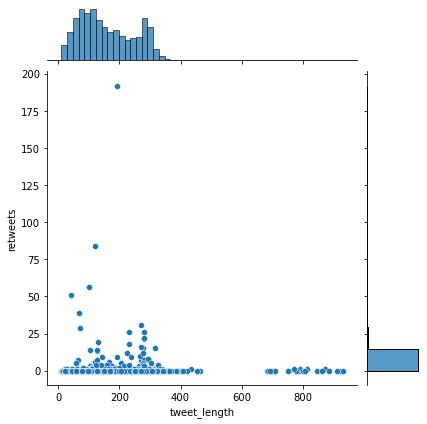

In [122]:
sns.jointplot(y='retweets', x='tweet_length', data = df);

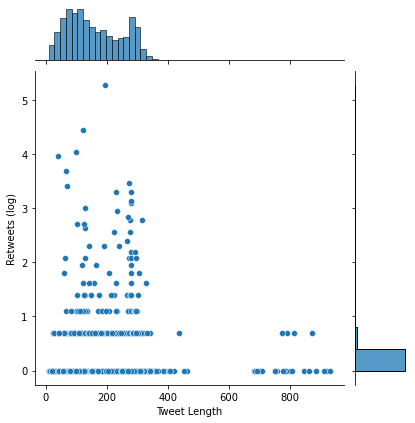

In [123]:
# Because retweets are so skewed, let's log them
p = sns.jointplot(y=np.log(df.retweets + 1), x='tweet_length', data = df)
p.set_axis_labels('Tweet Length','Retweets (log)');

'@JohnCornyn @WSJ Wtf does this even mean? How do you people live with yourselves? You literally have to bend like pretzels to excuse wrongdoings of Trump and his people.'